In [1]:
import sys

sys.path.append("../..")

from sqlalchemy import func

from inspect import getmembers
import os
import pandas as pd
from shapely.geometry import Polygon
from src.models import *
from src import crud
from src.pingers import *
from src.database.session import db
from src.image_analysis.rekognition.utils import *
from src.image_analysis.relevant_uuids import text_uuids, face_uuids
from src.utils import *
from src.s3.image import s3_image
import boto3
from tqdm import tqdm
import random
import uuid

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sanjinjuricfot/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjinjuricfot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-05-08 10:08:36.623 | DEBUG    | src.database.session:<module>:17 - base: prod.cw6tznt1p9hq.us-east-1.rds.amazonaws.com


In [2]:
df = pd.read_csv(f'{os.getenv("GLOBAL_PATH_TO_REPO")}/data/url_performance.csv')
urls = df.url.unique()
len(urls)

681

In [3]:
# image_folder = "data/fb_images/images"
# for url in tqdm(urls):
#     image = download_image_from_url(image_url=url)
#     save_image_to_s3(image=image, path=f"{image_folder}/{uuid.uuid1()}.png")

In [22]:
image_folder = "data/fb_images/images"
image_paths = list_objects_from_prefix(prefix=image_folder)
# image_paths = [path for path in image_paths if any([uid in path for uid in face_uuids])]
image_paths = random.sample(image_paths, 30)
images = []

for path in set(image_paths):
    image = RekognitionImage(path=path, add_global_path=False)
    images.append(image)
i = 0

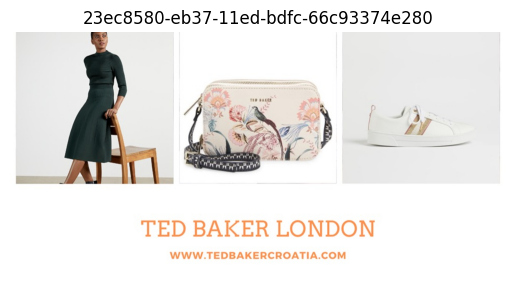

In [33]:
image = images[i]
image.plot()
labels = image.detect_labels(max_labels=15)
i += 1

In [34]:
labels = [label.name for label in labels]
labels

['Shoe',
 'Accessories',
 'Bag',
 'Handbag',
 'Adult',
 'Female',
 'Person',
 'Woman',
 'Sneaker',
 'High Heel',
 'Long Sleeve',
 'Purse',
 'Furniture',
 'Tote Bag',
 'Dress']

In [59]:
with open('relevant_uuids.py', 'a') as file:
    file.write(f"'{image.name}',\n")

image = images[0]


In [5]:
labels = image.detect_text(Filters=TEXT_FILTERS)
text = '\n'.join([label.text for label in labels if label.kind == 'LINE'])
print(text)

GET 10% OFF YOUR
FIRST ORDER
Step
One
Foods
TM
physician formulated


In [56]:
print(text)

SMITHEY
COMPANY
Modern cookware with an old soul.
Hand-crafted to elevate your cooking experience.


In [9]:
labels[0].to_dict()

{'text': 'GET 10% OFF YOUR',
 'kind': 'LINE',
 'polygon': [{'X': 0.07585852593183517, 'Y': 0.073999784886837},
  {'X': 0.9111327528953552, 'Y': 0.073999784886837},
  {'X': 0.9111327528953552, 'Y': 0.13446220755577087},
  {'X': 0.07585852593183517, 'Y': 0.13446220755577087}],
 'confidence': 100.0}

In [21]:
df = pd.DataFrame([(label.text, label.geometry['BoundingBox']["Height"]) for label in labels if label.kind == 'LINE'], columns=['text', 'height'])
df

,text,height
0,GET 10% OFF YOUR,0.060462
1,FIRST ORDER,0.059570
2,Step,0.038374
3,One,0.062211
4,Foods,0.034180
5,TM,0.008789
6,physician formulated,0.067777


In [22]:
max_height = df.height.max()
df[df.height >= max_height*0.8]

,text,height
0,GET 10% OFF YOUR,0.060462
1,FIRST ORDER,0.059570
3,One,0.062211
6,physician formulated,0.067777


In [24]:
df.height.idxmax()

6

In [26]:
df

,text,height
0,GET 10% OFF YOUR,0.060462
1,FIRST ORDER,0.059570
2,Step,0.038374
3,One,0.062211
4,Foods,0.034180
5,TM,0.008789
6,physician formulated,0.067777


In [27]:
df.loc[df.height.idxmax(), 'text']

'physician formulated'

In [166]:
[label.text for label in labels]

['literally', 'changing', 'just', 'literally', 'changing', 'just']

In [160]:
text = ' '.join([label.text for label in labels if label.kind == 'LINE'])
text

'TEATIME'

In [144]:
with open('images_with_text.py', 'a') as file:
    file.write(f"'{image.name}',\n")

In [18]:
df = read_csv_from_s3("global/data/texts_2022.csv")

In [19]:
df

,Unnamed: 0,shop_id,account_id,ad_id,primary,description,title,industry
0,5,96,740587486140754,23849291873500023,[Visit our LA store and receive a free P.F. Ca...,[Our first store is officially open at ﻿﻿8402 ...,"[8402 MELROSE AVE, WEST HOLLYWOOD, CA!]",unknown
1,6,96,740587486140754,23849419902350023,[New Year Luxe. Free 2-Day Shipping On All Ord...,[],[We're feeling '22],unknown
2,7,96,740587486140754,23849453622440023,[Take 20% off all ﻿dresses for every occasion ...,[Take 20% off all dresses!],[The Dress Sale],unknown
3,8,96,740587486140754,23849453802350023,[Take 20% off all ﻿dresses for every occasion ...,[Take 20% off all dresses!],[],unknown
4,9,96,740587486140754,23849512241060023,[Our Anniversary Sale Starts Now! ﻿EXTRA 40% o...,[EXTRA 40% off sale styles],[Don't miss our biggest sale of the year!],unknown
...,...,...,...,...,...,...,...,...
16816,17173,74399413,29892839,6290453197161,[Summer full of colors 🤍☀️🌊],[],[],unknown
16817,17174,79497608,1786466174994988,23850247601380115,"[It's time for a coffee full of flavor, not su...",[Clean coffee should taste good],[Coconut Water Iced Coffee],unknown
16818,17175,79993181,213501581,6274482509344,[Fresh seasonal produce delivered to your door...,[],[],unknown
16819,17176,79993181,213501581,6275214193944,[Fresh vegetables! \n\nMin order $40\n\nView p...,[],[],unknown


In [5]:
df = read_csv_from_s3(s3_image.final_by_shop_df)

In [13]:
df.groupby(["shop_id"])["spend_USD"].sum().sort_values(ascending=False).head(30)

shop_id
99677322.0     2.539210e+06
16002430.0     1.113024e+06
3397559.0      8.316542e+05
268714.0       6.701079e+05
14486167.0     6.661253e+05
18600257.0     6.446170e+05
96659600.0     4.357669e+05
10080134.0     3.316777e+05
43247895.0     3.295536e+05
34237718.0     2.272429e+05
83029637.0     2.107841e+05
19505868.0     1.243176e+05
27227973.0     1.138900e+05
45867058.0     1.126442e+05
15433380.0     1.101739e+05
22502944.0     1.068726e+05
46167900.0     1.068479e+05
46317801.0     1.030681e+05
98938809.0     1.004413e+05
28932952.0     8.275415e+04
10248339.0     7.428907e+04
39346644.0     7.385454e+04
159350.0       7.352848e+04
42787782.0     7.268251e+04
43375757.0     6.921475e+04
39106511.0     6.697516e+04
40896545.0     6.644792e+04
100474898.0    6.257207e+04
38955025.0     6.037485e+04
24640760.0     6.036473e+04
Name: spend_USD, dtype: float64

In [15]:
urls = db.query(Image.url).filter(func.random() > 0.99, Image.source == "facebook").limit(100).all()
urls = [row.url for row in urls]

In [16]:
imgs = []
for url in urls:
    img = download_image(img_url=url, convert_to_rgb=True)
    if img is not None:
        imgs.append(img)
len(imgs)

0

In [13]:
plot_list_of_images(imgs)

<Figure size 2000x0 with 0 Axes>

In [2]:
shop_ids = db.query(Image.shop_id).filter(Image.source == "facebook").distinct().all()
shop_ids = pd.Series([row.shop_id for row in shop_ids])

In [3]:
df = ping_image_urls_and_ad_performance_per_shop(db=db, shop_id=shop_ids[0])

In [2]:
rekognition_client = boto3.client("rekognition")
img_path = f'{os.getenv("GLOBAL_PATH_TO_REPO")}/data/bernardo.png'
with open(img_path, "rb") as file:
    img_bytes = file.read()
img = cv2.imread(img_path)
img = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB).astype(np.uint8)

In [3]:
rkgn_img = RekognitionImage(
    img_bytes=img_bytes,
    img_name="bernardo",
    rekognition_client=rekognition_client,
    minboundingbox_height=0.05,
)
labels = rkgn_img.detect_text()
labels

2023-05-04 15:28:33.086 | INFO     | src.image_analysis.rekognition.RekognitionImage:detect_text:129 - Found %s texts in %s.


In [4]:
set([label.text for label in labels])

{'2', 'T'}

In [32]:
label = labels[4]
label.text

'ETIHAD'

In [8]:
label.geometry

{'BoundingBox': {'Width': 0.027947282418608665,
  'Height': 0.021162644028663635,
  'Left': 0.8400550484657288,
  'Top': 0.4480012059211731},
 'Polygon': [{'X': 0.8400550484657288, 'Y': 0.4564096927642822},
  {'X': 0.8634105920791626, 'Y': 0.4480012059211731},
  {'X': 0.8680023550987244, 'Y': 0.4607553482055664},
  {'X': 0.8446468114852905, 'Y': 0.46916383504867554}]}

In [9]:
img.shape

(1707, 2560, 3)

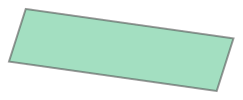

In [33]:
height, width, _ = img.shape
relative_coords = label.to_dict()["polygon"]
relative_coords = [tuple(coord.values()) for coord in relative_coords]
apsolute_coords = [(x * width, y * height) for x, y in relative_coords]
pol = Polygon(apsolute_coords)
pol

In [34]:
apsolute_coords

[(1100.8665466308594, 724.9721450507641),
 (1309.6876525878906, 695.3755045831203),
 (1326.5451049804688, 748.257993042469),
 (1117.7239990234375, 777.8546335101128)]

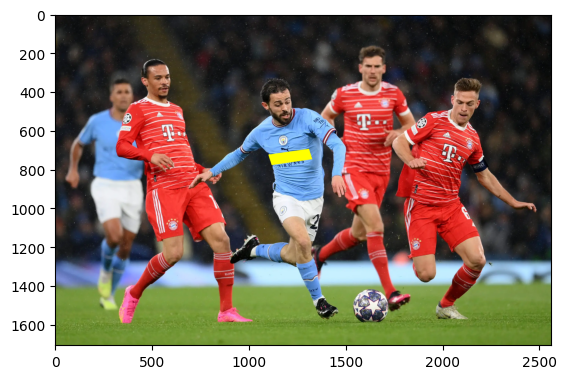

In [37]:
overlay = img.copy()
int_coords = lambda x: np.array(x).round().astype(np.int32)
exterior = [int_coords(pol.exterior.coords)]
cv2.fillPoly(overlay, exterior, color=(255, 255, 0))
plt.imshow(overlay)

In [15]:
int_coords = lambda x: np.array(x).round().astype(np.int32)
exterior = [int_coords(pol.exterior.coords)]
overlay = img.copy()
# alpha = 0.5
# cv2.fillPoly(overlay, exterior, color=(255, 255, 255))
# cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
# cv2.imshow("Polygon", img)

In [16]:
exterior

[array([], shape=(0, 2), dtype=int32)]